# Lab 5: Bootstrap and Hypothesis Testing
Welcome to the fifth DS102 lab! 

The goal of this lab is to implement bootstrap techniques to perform hypothesis testing in settings where it would be very difficult to do so with parametric techniques. This week's Discussion and Lab are adapted from an example from [Statistics 24600 at UChicago](http://galton.uchicago.edu/~eichler/stat24600/Handouts/bootstrap.pdf). This week's Discussion will go over some of the theory behind this Lab -- so make sure you look at it first.


#### The code and responses you need to write are commented out with a message  `TODO: fill in`. There is additional documentation for each part as you go along.

##### Please read carefully the introduction and the instructions to each problem.

## Collaboration Policy
Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

## Gradescope Submission
To submit this assignment, rerun the notebook from scratch (by selecting Kernel > Restart & Run all), and then print as a pdf (File > download as > pdf) and submit it to Gradescope.


**This assignment should be completed and submitted before Thuesday, Oct 8, 2020 at 11:59 PM. PST**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from math import pi, exp, sqrt
from ipywidgets import interact, interactive
import itertools
import hashlib

from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
  
sns.set(style="dark")
plt.style.use("ggplot")

def get_hash(num, significance = 4):
    num = round(num, significance)
    """Helper function for assessing correctness"""
    return hashlib.md5(str(num).encode()).hexdigest()

/Users/mcurmei/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Goal: testing for multimodality
Suppose that $X_1, . . . , X_n$ are an i.i.d. sample from a distribution with continuous density $p(x)$.
One important property of the density $p(x)$ is the number of modes it has. Multimodality of
the density indicates a heterogeneity in the data. In this lab, we will demonstrate how to perform a hypothesis test to determine whether a distribution is multimodal. We'll use the Bootstrap Method to perform this hypothesis test.


# Galaxy data

In this lab we will be working with galaxy data. The dataset contains velocities in km/sec of 82 galaxies from 6 well-separated conic sections of an unfilled survey
of the Corona Borealis region. The distribution
of galaxy velocities provides information about the structure of the far universe—in
particular, a multimodal distribution of velocities is seen as evidence for the existence
of voids and superclusters.

Let $X_1, . . . , X_{n}$ be the velocities of each galaxy, where $X_i$ is the velocity of the $i$th galaxy and we observe $n=82$ galaxies.

We want to test whether or not the distribution that the $X_i$'s are drawn from is multimodal. Let the null and alternative hypotheses be defined as follows:

$$H_0: m(p) = 1$$ 
$$H_A: m(p) > 1$$ 

where $p$ is the distribution of galaxy velocities, and $m(p)$ is the number of modes of a distribution $p$.


## Load the data

First, we'll load the data and see what the histogram looks like.

In [3]:
galaxies_df = pd.read_csv('galaxies.csv', index_col=0, header=0, names=['velocity'])
# Divide all entries by 1000 for ease of reading.
galaxies_df['velocity'] = galaxies_df['velocity'] / 1000
X_observed = np.array(galaxies_df['velocity'])
galaxies_df.head()

,velocity
1,9.172
2,9.350
3,9.483
4,9.558
5,9.775


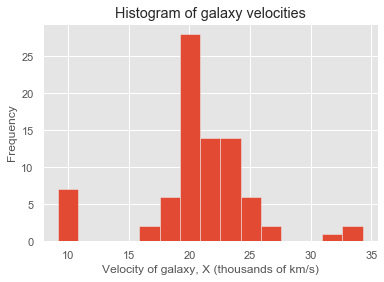

In [4]:
plt.hist(X_observed, bins=15)
plt.title("Histogram of galaxy velocities")
plt.xlabel("Velocity of galaxy, X (thousands of km/s)")
plt.ylabel("Frequency")
plt.show()

# 1. Estimating the density and test statistic

In order to infer whether or not the $X_1,...,X_{n}$ were drawn from a multimodal distribution, we need to come up with a test statistic that somehow reflects how suitable a unimodal distribution is for
modeling this data. 

To do this, we first need to come up with a model for the density function itself. In this lab you will have the chance to learn about a non-parametric density estimatation technique called *kernel density estimation*.

#### Kernel Density Estimation
Given a set of points $X_1, X_2, \ldots, X_n \sim p(x)$. The goal of Kernel Density Estimation is to estimate the density $p(x)$ via a function $\hat{p}_h(x)$ of the form:

\begin{align}
\hat{p}_h(x) = \frac{1}{nh} \sum_{i=1}^n K\left(\frac{x - X_i}{h}\right) 
\end{align}
 

The function $K$ is a non-increasing function that takes only non-negative values. These functions are known as kernel functions. They are often used to capture the influence of each data point $X_i$ on the density of an arbitrary point $x$. A common choice of kernel is the Gaussian kernel, which is what we will use from now on in this lab: 

$$K(x) = \frac{1}{\sqrt{2\pi}} \exp(-x^2/2)$$

_Take a few moments to convince yourself that $K$ is non-negative and non-increasing._

In addition, the parameter $h > 0$ is a bandwidth parameter that captures how close data points $X_i$ must be to $x$ to influence its density: for larger values of $h$, more data points have an
influence on the density at $x$, whereas for smaller values of $h$, only data points very close
to $x$ influence it.

It can be shown that the number of modes of $\hat{p}_h(x)$ (a.k.a. $m(\hat{p}_h(x))$) decreases monotonically as $h$ increases. Therefore, $h$ will be an important tool in our hypothesis test.

## 1.a. Plot the density estimates $\hat{p}_h(x)$

Using the kernel function $K(x) = \frac{1}{\sqrt{2\pi}} \exp(-x^2/2)$, we will first plot $\hat{p}_h(x)$ to get a sense of what these density estimates look like for different values of $h$.

\begin{align*}
\hat{p}_h(x) &= \frac{1}{nh} \sum_{i=1}^n K\left(\frac{x - X_i}{h}\right) \\
&= \frac{1}{nh} \sum_{i=1}^n \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{(x - X_i)^2}{2h^2}\right) \\
&= \frac{1}{nh \sqrt{2\pi}} \sum_{i=1}^n \exp\left(-\frac{(x - X_i)^2}{2h^2}\right) \\
\end{align*}

Using the final simplified form above, implement a function that calculates $\hat{p}_h(x)$ at a given point $x$.

In [5]:
#  TODO: fill in.
def p_hat(x, h, X):
    """Calculates p_hat(x) at a single point x, where the bandwidth of the kernel function is h.
    
    Inputs: 
      x : float, point at which to evaluate the function p_hat.
      h : float, bandwidth parameter in kernel function.
      X : array of floats of length n containing the observed galaxy velocities.
      
    Outputs:
      y: float, the value of p_hat(x) at the given point x.
    """
    n = len(X)
    total = np.sum(np.exp(-((x - X)**2) / (2 * h**2)))
    y = total /  (n * h * sqrt(2 * pi)) # TODO: fill in 
    return(y)

In [6]:
# Validation tests: Do not modify
x_values = [10, 15, 20, 25, 30, 35]
h_values = [0.5, 1, 2, 5, 10]
inputs = list(itertools.product(x_values, h_values))
outputs = [p_hat(*inp, X_observed) for inp in inputs]
hash_list = ['bfde2cf30f9e9ce79408d99cab3e8bc8', '0574a27738923dd052ed0b873c176afc', '78b6d148d48bbea1345c899ca9e46909', 
 'f4ee6417f4b3ac1be9eb6568e73144b6', '3ffdc10d8a61ad159f223313dfbc03e2', '605849c8f83de4da7c6fd144d7f58826', 
 '3f372d09d37f32da442cb9ee0ac460f0', '5b3bc4848902c9a21de80767f9e339b8', '71c61135ff01aa84ee86864b86711f5b', 
 '04d8f0e70a01305f62dbadaa76a8f7cb', '45bd1e472af7b3bc57dc9312833c17a0', '45367152f5d7346868703d4980f60e03', 
 '27e795eb0f314edf0479737480ab0f2a', 'd16aea76e1e1217b7eb5f7395948d364', 'd9cd4af75fe14d77a6faa0335f83b8c0', 
 '2f6f54bd4207339ea29d730563c34b14', '2e0bfa827d51449a197fae6ab9f4804c', 'e0e4a546725d40f259b552ae41932f38', 
 'ee15c394e25320ba6ce793eeaef72cdb', '9740966b3dc9d6fd0efba0313c963536', '30565a8911a6bb487e3745c0ea3c8224', 
 '7f77a1b9954bf3ae6f43c6298871aeda', 'e5b43ca16f1f9cf6cbcfa71cdc7220ae', '83441ddfbbdcf553b5efe63b81eb1832', 
 '2a6b856fad8c51aed13cfd58c948b380', '3b15219be5ebd7c0831dc46746a52d3c', '870b8425c55942fe40463327364cb546', 
 'a2eb92865432da0c58cef552428f4ed1', 'dfff58ed1f9b7657068b28b69b62d70e', 'ee217454afa3c02cb3f1799b5aad3608']
for i, inp in enumerate(inputs):
    print('For x={} and h={} the value of p_hat is {}'.format(*inp, outputs[i]))
    assert(get_hash(outputs[i])==hash_list[i])
print('Test passed!')

For x=10 and h=0.5 the value of p_hat is 0.043502122432280646
For x=10 and h=1 the value of p_hat is 0.030026013640726264
For x=10 and h=2 the value of p_hat is 0.016530138724089653
For x=10 and h=5 the value of p_hat is 0.013967855793789412
For x=10 and h=10 the value of p_hat is 0.021926134614069594
For x=15 and h=0.5 the value of p_hat is 0.0015575391599632143
For x=15 and h=1 the value of p_hat is 0.00519520776222485
For x=15 and h=2 the value of p_hat is 0.010784571470806413
For x=15 and h=5 the value of p_hat is 0.036346588784896126
For x=15 and h=10 the value of p_hat is 0.03140794584332124
For x=20 and h=0.5 the value of p_hat is 0.19868844845841
For x=20 and h=1 the value of p_hat is 0.15019369808301325
For x=20 and h=2 the value of p_hat is 0.11000604476729897
For x=20 and h=5 the value of p_hat is 0.063136488323517
For x=20 and h=10 the value of p_hat is 0.03653220304335537
For x=25 and h=0.5 the value of p_hat is 0.037353630386100754
For x=25 and h=1 the value of p_hat is 0

In [7]:
# No need to modify: Just run this cell after you pass the validation tests above
def plot_density_estimate(h):
    x_values = np.arange(0, 45, 0.5)
    y_values = [p_hat(x, h, X_observed) for x in x_values]
    fig = plt.figure(figsize=(9,6))
    plt.hist(X_observed, bins=15, density=True, label="Histogram of observed values")
    plt.plot(x_values, y_values, label = "Estimated kernel density")
    plt.title("Density $\hat{p}_h(x)$")
    plt.ylabel("Density $\hat{p}_h(x)$")
    plt.xlabel("Velocity, x")
    plt.legend()
    plt.show()

In [8]:
# Visualize interactive plot: Do not modify
interactive_plot = interactive(plot_density_estimate, h=(0.1, 4, 0.1))
interactive_plot 

interactive(children=(FloatSlider(value=2.0, description='h', max=4.0, min=0.1), Output()), _dom_classes=('wid…

## 1.b.
### (i) Start with a small value of $h=0.1$, then slide the value of $h$, what do you observe? 
### (ii) Does the density estimate $\hat{p}_h(x)$ seem to contain more modes for higher values of $h$ or lower values of $h$?
### (iii) For what values of $h$ (small or large), does $\hat{p}_h(x)$ fit the current data more closely? Would this value generalize well to other unseen data?

TODO: fill in your answer.


(i) When $h$ is small the estimated kernel density is very closed to the empirical distribution. Increasing $h$ makes the kernel density estimate much smoother.

(ii) At lower values of $h$ the data has more modes. In the limit that $h \to 0$, the number of modes $\to N$. As $h$ increases, the density is more smooth and has fewer modes.

(iii) For very small values of $h$ the density estimate is just exactly the empirical distribution, so it tautologically fits the data best. However this will not generalize to other unseen data.

# 2. Count the modes of $\hat{p}_h(x)$

Now we will write a function that counts the number of modes of a given density estimate $\hat{p}_h(x)$. This is the $m(p)$ function mentioned above. 

To do this, we say that a density function $p$ has a mode everywhere the function $p(x)$ has an increase followed by a decrease. That is, $p(x)$ has an additional mode for each time the derivative of the function $p(x)$ transitions from non-negative to negative.

Following the above definition, to count the number of modes in $\hat{p}_h(x)$, first we will take the derivative, $$\frac{d}{dx}\hat{p}_h(x).$$

Then, we will count the number of times that the derivative transitions from positive (or 0) to negative over a grid of $x$'s.

## a. Calculate the derivative $\frac{d}{dx}\hat{p}_h(x).$

Using the kernel function $K(x) = \frac{1}{\sqrt{2\pi}} \exp(-x^2/2)$, we will now calculate the derivative $\frac{d}{dx}\hat{p}_h(x)$ by applying the chain rule.

\begin{align*}
\frac{d}{dx}\hat{p}_h(x) &= \frac{d}{dx} \frac{1}{nh} \sum_{i=1}^n K\left(\frac{x - X_i}{h}\right) \\
&= \frac{1}{nh} \sum_{i=1}^n \frac{d}{dx} K\left(\frac{x - X_i}{h}\right) \\
&= \frac{1}{nh} \sum_{i=1}^n \frac{1}{h} K'\left(\frac{x - X_i}{h}\right) \\
&= \frac{1}{nh^2} \sum_{i=1}^n \frac{1}{\sqrt{2\pi}} \frac{-(x - X_i)}{h} \exp
\left(-\frac{\left(\frac{x - X_i}{h}\right)^2}{2}\right) \\
&= \frac{1}{nh^3 \sqrt{2\pi}} \sum_{i=1}^n (X_i - x)\exp
\left(-\frac{(x - X_i)^2}{2h^2}\right) \\
\end{align*}

### Using the final simplified form of the derivative above, implement a function that calculates $\frac{d}{dx}\hat{p}_h(x)$ at a given point $x$.

In [9]:
# TODO: Implement the derivative of the density function phat.
def p_hat_derivative(x, h, X):
    """Calculates the derivative d/dx p_hat(x) at a single point x.
    
    Inputs: 
      x : float, point at which to evaluate the derivative.
      h : float, bandwidth parameter in p_hat.
      X : array of floats of length n containing the observed galaxy velocities.
      
    Outputs:
      y_prime : float, the derivative d/dx phat_h(x) at the given point x.
    """
    n = len(X)
    total = np.sum((X - x) * np.exp(-((x - X)**2) / (2 * h**2)))
    y_prime = total / (n * h**3 * sqrt(2 * pi)) # TODO
    return(y_prime)

In [10]:
# Validation tests: Do not modify
x_values = [10, 15, 20, 25, 30, 35]
h_values = [0.5, 1, 2, 5, 10]
inputs = list(itertools.product(x_values, h_values))
outputs = [p_hat_derivative(*inp, X_observed) for inp in inputs]
hash_list = ['4d0f910141950d0552516b08262c6d88', 'ee1e0a7c5f3203b121321e10ef9ebfcc', 
             '9d74396d5f50aada0f76b53876289877', 'e5d1865cd14e2e2797315f411c865d34', 
             'd1c6c5ed1452a2c20690b2d93a4f00e0', 'bc0aa7760f949f3f261bd22cccb0be88', 
             'af15b8f51b361f749e298266d1b59221', 'bc0aa7760f949f3f261bd22cccb0be88', 
             '8fafaedad116ebf18ae0c9815be36d64', '605849c8f83de4da7c6fd144d7f58826',
             'af4aa469cb849835c30a124d5d1bc107', 'c2cbc317b75f876eaf979554f31dda6a', 
             '3ca9a3c86b0760635f3df430065bb8f6', 'b0d9065d75ae926cd362fba71d69b52b', 
             'e495db35efd570a55591de3837f0ad14', 'e6a87177121c61d8c869ac6a6b1fbf27',
             '1d2cfabfe25e3044b685f90d10ba21cc', '44aacd1208bcd231cb57e2b1e754e980', 
             '4aca2fa353792a6eacf7a83c0b7b5160', 'b9e7b54550fc3121a8ec2d20fb6829d7', 
             '30565a8911a6bb487e3745c0ea3c8224', '3dae501e7f083a41cfbcb44adc05bda1', 
             'cd6d97983b00e021e9c98b7c98d18c9d', '27dff86ccacff92bcbfee45308bf1e7e', 
             '946cd8046a64ba7f47cda2b01242b4bd', '2de90d3403001c283e5c25b5f6de7136', 
             '92d7818cdd51f18a20c81c926703ada6', '4b2cf601f8a8bcc16b098ec9976641e3',
             'b25679011e386ab0c912204ef86d5d73', '652eb2b63d10f43925443c94772e60f2']
for i, inp in enumerate(inputs):
    assert(get_hash(outputs[i])==hash_list[i])
print('Test passed!')

Test passed!


In [12]:
# No need to modify: Just run this cell after you pass the validation tests above
def plot_density_derivative(h):
    x_values = np.arange(4, 36, 0.5)
    y_values = [p_hat_derivative(x, h, X_observed) for x in x_values]
    fig = plt.figure(figsize=(9,6))
    plt.plot(x_values, y_values)
    plt.axhline(0, c = 'k', ls = "--")
    plt.title("Derivative of the density $\hat{p}_h(x)$")
    plt.xlabel("Velocity, x")
    plt.show()

In [13]:
# Visualize interactive plot: Do not modify
interactive_plot = interactive(plot_density_derivative, h=(0.1, 4, 0.1))
interactive_plot 

interactive(children=(FloatSlider(value=2.0, description='h', max=4.0, min=0.1), Output()), _dom_classes=('wid…

### (i) Slide the value of $h$ from 0.1 to 4. What do you observe?
### (ii) For what values of $h$ do does the derivative close the 0 line more often? For small values of $h$ or larger values of $h$?

When $h$ is really small the derivative is very 'wiggly' and it frequently crosses the 0 line. As $h$ increases, it crosses the 0 line only once.


## 2.b. Count the number of modes in $\hat{p}_h(x)$

Using the derivative calculated above, we will now count the number of modes in $\hat{p}_h(x)$.

To do this, we will evaluate the derivative $\frac{d}{dx}\hat{p}_h(x)$ at a grid of points $x_1,...,x_m$ evenly spaced between $5$ and $35$ (the lower and upper bounds on the velocities in the data), and count the number of times that the derivative crosses from positive to negative.  The use of a grid of $x$'s isn't a perfect measurement of the mode count, since if we don't evaluate the derivative at enough points that are close enough together, we may miss some modes. In this lab we will make sure that the grid we use is fine enough to accurately count the number of modes.

In [14]:
# Count the modes of phat using the derivative implemented above.
def count_modes(x_values, h, X):  
    """Counts the number of modes in p_hat(x), approximated over the given grid of x_valies.
    
    Counts a mode every time the derivative of p_hat(x) crosses from positive (or 0)
    to negative over the given grid of x_values.
    
    Inputs: 
      x_values : array of floats of length m 
      containing points at which to evaluate the derivative.
      h: float, bandwidth parameter in phat_h.
      X: array of floats of length n containing the observed galaxy velocities.
      
    Outputs:
      num_modes : int, the number of modes in p_hat(x).
    """
    # First calculate the derivative at all points in x_values.
    all_derivatives = [p_hat_derivative(x, h, X) for x in x_values]
    
    # Iterate through all of the calculated derivatives, 
    # and add a mode every time the derivative crosses from positive (or 0) to negative.
    num_modes = 0
    for i in range(0, len(all_derivatives)-1):
        if (all_derivatives[i] >= 0) and (all_derivatives[i + 1] < 0):
            num_modes += 1
    
    return num_modes

In [15]:
# Validation tests: do not modify
x_values = np.arange(5,35,0.05)
h_values = [0.5, 1, 2, 5, 10]
outputs = [count_modes(x_values, h,  X_observed) for h in h_values]
hash_list = ['8f14e45fceea167a5a36dedd4bea2543','eccbc87e4b5ce2fe28308fd9f2a7baf3',
    'eccbc87e4b5ce2fe28308fd9f2a7baf3','c4ca4238a0b923820dcc509a6f75849b','c4ca4238a0b923820dcc509a6f75849b']
for i, out in enumerate(outputs):
    assert(get_hash(outputs[i])==hash_list[i])
print('Test passed!')

Test passed!


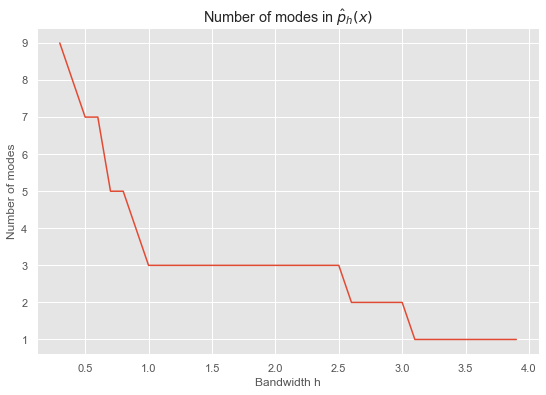

In [16]:
# No need to modify: Plot the number of modes for different values of h.
# This cell may take a few seconds to run.
x_values = np.arange(5,35,0.05)
h_values = np.arange(0.3,4,0.1)
mode_counts = [count_modes(x_values, h, X_observed) for h in h_values]

fig = plt.figure(figsize=(9,6))
plt.plot(h_values, mode_counts)
plt.title("Number of modes in $\hat{p}_h(x)$")
plt.ylabel("Number of modes")
plt.xlabel("Bandwidth h")
plt.show()

# 3. Hypothesis test

Now that we've defined the density estimate $\hat{p}_h(x)$ and figured out how to count the number of modes in $\hat{p}_h(x)$, we will move on to testing whether or not a multimodal distribution can reasonably fit our data $X_1,...,X_n$.

In the plot in part 2.b. you should have observed that the number of modes in $\hat{p}_h(x)$ decreases monotonically as $h$ increases. Let $H_1$ be the minimal bandwidth value $h$ for which $\hat{p}_h(x)$ is unimodal. 

\begin{align}
    H_1 & = \min \{h \colon m(\hat{p}_h) = 1, \, m(\hat{p}_{h'}) > 1 \text{ for all } h' < h\}.
\end{align}

Similarly we define $H_k$ to be the minimal bandwidth value $h$ for which $\hat{p}_h(k)$ has $k$ modes:

\begin{align}
    H_k & = \min \{h \colon m(\hat{p}_h) = k, \, m(\hat{p}_{h'}) > k \text{ for all } h' < h\}.
\end{align}

We will use $H_k$ as the test statistic. 

Notice that $H_k$ depends on the data $X$, because the function $\hat{p}_h(x)$ depends on the data $X$.

For our particular observed dataset $X_{observed}$, let $h_k$ be the observed minimal bandwidth value $h$ for which $\hat{p}_h(x)$ has $k$ modes.


## Calculate $H_k$
The first thing we need to do is calculate $H_k$ for a given dataset $X$. To do this, we will try different values of $h$ until we find the smallest value such that the density estimate $\hat{p}_h$ has $k$ modes. The function below accomplishes that. Take a few minutes to examine it and understand what it is doing.

In [17]:
# No TODOs here, just understand what this function is doing.
def find_hk(x_values, X, h_min=0.3, h_max=4, h_err = 0.01, k=1):
    """
    Calculates h_k, the minimum bandwidth h such that the density estimate p_hat has k modes.
    Chooses h_k from within an interval bounded by h_min and h_max, within error h_err.
    
    Inputs:
      x_values: array of floats containing points x to use to count the number of modes in p_hat.
      X: array of floats of length n containing the observed galaxy velocities.
      h_min: float, minimum h to try.
      h_max: float, maximum h to try.
      h_err: float, allowed error of h, or step size of hs to try between h_min and h_max.
      k: number of modes being tested in the hypothesis test.
      
    Returns:
      h_k: minimum bandwith h among candidate h_values such that p_hat has k modes.
    """
    # Perform a binary search to find the minimum bandwith hk.
    h_opt = 0
    modes_min = count_modes(x_values, h_min, X)
    modes_max = count_modes(x_values, h_max, X)
    while h_max - h_min > h_err:
        h_opt = (h_min + h_max) / 2
        modes_opt = count_modes(x_values, h_opt, X)
        if modes_opt > k:
            h_min = h_opt
            modes_min = modes_opt
        else:
            h_max = h_opt
            modes_max = modes_opt
    return h_max

The function above calculates the test statistic $H_k$. To calculate the value $h_1$ for the null hypothesis, we apply this same function over the observed data $X_1,...,X_n$. Run the cell below and compare the outputs with the plot in 2.b.

In [18]:
# No TODOs here, just run this cell to calculate the value of h_k using the function above.
# This cell might take a minute or so to run
x_values = np.arange(5,35,0.05)
for k in range(1,10):
    hk = find_hk(x_values, X_observed, k=k)
    print("For k = {}. Estimate value of h_{}: {:.4f}".format(k, k, hk))

For k = 1. Estimate value of h_1: 3.0461
For k = 2. Estimate value of h_2: 2.5041
For k = 3. Estimate value of h_3: 0.9359
For k = 4. Estimate value of h_4: 0.8854
For k = 5. Estimate value of h_5: 0.6758
For k = 6. Estimate value of h_6: 0.6686
For k = 7. Estimate value of h_7: 0.4518
For k = 8. Estimate value of h_8: 0.3650
For k = 9. Estimate value of h_9: 0.3072


##  Computing the $p$-value

Let's say we are trying to test that the distribution of galaxies' velocities is unimodal. The corresponding test statistic is $H_1$ and the observed realization is $h_1$. Therefore, the $p$-value for our hypothesis test is: 

$$P_{0}(H_1 \geq h_1)$$

where $P_0$ is the probability under the null hypothesis that the $X_i$ are drawn from a unimodal distribution. This $p$-value represents the probability under the null hypothesis that we observe a value as extreme as $h_1$ for the minimum width parameter.

To perform a hypothesis test at significance level $\alpha$, we reject the null hypothesis if the $p$-value is less than $\alpha$:
$$P_{0}(H_1 \geq h_1) \leq \alpha. $$

Now, we need to calculate the $p$-value. Unfortunately, we don't have a closed form for the distribution of the test statistic $H_1$ under the null hypothesis that the $X_i$ are drawn from a unimodal distribution. In fact, we don't even know what distribution the $X_i$ are drawn from, only that it's unimodal (under the null hypothesis)! Still, to estimate the distribution of the test statistic $H_1$, we need to pick some distribution to use for the distribution of the $X_i$'s under the null hypothesis.

Among the parameterized densities $\hat{p}_h(x)$, the density $\hat{p}_{h_1}(x)$ is the closest unimodal distribution  to the empirical distribution $p$ of the observed data. So, we will use $\hat{p}_{h_1}(x)$ as the distribution of the $X_i$'s under the null hypothesis.

Therefore, the $p$-value that we will calculate is $$P_{X_i \sim \hat{p}_{h_1}}(H_1 \geq h_1).$$

More generally, if instead we want to test the the distribution of  galaxies' velocities has at most $k$ modes can be calculated as:
$$P_{0}(H_k \geq h_k) \approx P_{X_i \sim \hat{p}_{h_k}}(H_k \geq h_k)$$

##  3.b. Sampling from $\hat{p}_{h_k}$ using the Bootstrap Method

To calculate the $p$-value, we will first draw i.i.d. samples from $\hat{p}_{h_k}$, and then observe the number of times that the $H_k$ calculated from those samples is greater than or equal to $h_k$. We will use the bootstrap to draw the i.i.d. samples from $\hat{p}_{h_k}$.

Let $Z^{*} = (Z_1^*, \ldots, Z_{82}^*)$ denote a bootstrap sample from the dataset $X_{observed}$. It can be shown that by adding some scaled noise to the bootstrap samples we can obtain samples from the null distribution. More precisely: 
$Z_i^* + h_k \epsilon_i$ for $\epsilon_i \sim \mathcal{N}(0, 1)$ gives i.i.d. samples from $\hat{p}_{h_k}$.

This leads to the following bootstrap algorithm: 

1. Draw $B$ independent bootstrap samples $Z^{*(1)}, \ldots, Z^{*(B)}$ from the observed data. Then add some noise to them to get samples  $X^{*(1)}, \ldots, X^{*(B)}$ from the null distribution $\hat{p}_{h_1}$, where in spirit,
    \begin{align}
        X_i^{*(b)} & = Z_i^{*(b)} + h_k \epsilon_i^{(b)} \\
        \epsilon_i^{(b)} & \sim \mathcal{N}(0, 1)
    \end{align}
    
    However, since the variance of the bootstrap sample has been increased by adding the normal error term, the data are usually rescaled to have the same sample variance as the original observations. So, it will actually work better if we replace the equation above in the algorithm with 
    
    \begin{align}
        X_i^{*(b)} & = \bar{Z}^{*(b)} + (1 + h_k^2/\hat{\sigma}^2)^{-1/2} (Z_i^{*(b)} - \bar{Z}^{*(b)} + h_k\epsilon_i^{(b)}).
    \end{align}
    
    We'll use this more complicated variance scaling in the code. In the equation above we have:
    - $\bar{Z}^{*(b)}$ is the sample mean of the bootstrap samples $Z^{*(b)}$.
    - $\hat\sigma$ is the variance of the original observed data.
    - $h_k$ is the minimum bandwidth h such that the density estimate for the original observed data has k modes.
    - $\epsilon_i^{(b)} \sim \mathcal{N}(0, 1)$, iid Gaussian noise
    
   We will call $ X_i^{*(b)}$ **bootstrap replicates**. 
       
       
       
2. For each bootstrap replicate $X^{*{b}}$, evaluate the value of the test statistic $H_k^{*(b)}$.
    
3. Estimate the $p$-value as the fraction of time that the value of the test statistic evaluated on the bootstrap replicates is larger the the test statistic evaluated on the original observed data.
    \begin{align}
        \text{estimate of }  \mathbb{P}_0(H_k \geq h_k) = \frac{1}{B} \sum_{b = 1}^B 1[H_k^{*(b)} \geq h_k].
    \end{align}

In [21]:
def estimate_p_value(X, B, k=1):
    """Estimates the p-value for the hypothesis test.
    
    Inputs: 
      X: array of floats containing the observed galaxy velocities.
      B: int, number of bootstrap samples to draw.
      k: int, number of modes we are testing for.
    
    Outputs:
      p_value: float, an estimate of the p-value.
    """
    # Find hk for the distribution under the null hypothesis.
    x_values = np.arange(5,35,0.05)
    hk = find_hk(x_values, X, k=k)
    # Count of the number of times Hk >= hk.
    Hk_greater_count = 0
    # Variance of the observed data X for rescaling the data.
    X_var = np.var(X)
    n = len(X)
    for _ in range(B):
        # TODO: obtain the bootstrap sample Z*. 
        # Z_star should be an array of n samples drawn from the data array X, sampled with replacement.
        # Hint: use np.random.choice.
        Z_star = np.random.choice(X, size=n, replace=True)
        
        Z_bar = np.mean(Z_star) # TODO: fill in
        epsilon = np.random.normal(size=n)
        X_star = Z_bar + (1 / sqrt(1 + ((hk**2) / X_var))) * (Z_star - Z_bar + (hk * epsilon)) # TODO: fill in
        
        # Check if H1 >= h1. Instead of explicitly calculating H1 (which could take long), 
        # we are using a shortcut where we count the number of modes in X_star under bandwidth value h1.
        # If the counted number of modes is greater than the number of modes used to find h1 
        # for the observed data, then the bandwidth value H1 is greater than or equal to the bandwidth value h1.
        # This is true because of number of modes is monotonically decreasing in the bandwidth value h.
        modes = count_modes(x_values, hk, X_star)
        if modes > k:
            Hk_greater_count += 1
    p_value = Hk_greater_count / B 
    return(p_value)

In [22]:
# No TODOs here, run this cell to calculate the p-value.
p_val_1 = estimate_p_value(X_observed, 100, k=1)
print("p-value for test for more than 1 mode:", p_val_1)

p-value for test for more than 1 mode: 0.0


## c. Try testing for different numbers of modes.

If we reject the hypothesis that the distribution of the data has 1 mode, what about testing if the distribution has more than $k$ modes? We can apply the same techniques to test 

$$H_0: m(p) = k$$ 
$$H_A: m(p) > k$$ 

Below, we apply the same techniques to estimate the $p$-values for $k = 2$ and $k = 3$.

In [23]:
# No TODOs here, run this cell to calculate the p-value.
# k = 2
p_val_2 = estimate_p_value(X_observed, 100, k=2)
print("p-value for test for more than 2 modes:", p_val_2)

p-value for test for more than 2 modes: 0.0


In [24]:
# No TODOs here, run this cell to calculate the p-value.
# k = 3
p_val_3 = estimate_p_value(X_observed, 100, k=3)
print("p-value for test for more than 3 modes:", p_val_3)

p-value for test for more than 3 modes: 0.41


In [25]:
# Validation tests: Do not modify
assert(np.abs(p_val_1) <= 0.01)
assert(np.abs(p_val_2) <= 0.03)
assert(np.abs(p_val_3 - 0.46) <= 0.15)
print('Test Passed')

Test Passed


### Question: for which values of $k$ were you able to reject the null hypothesis? Did this match your expectation of the number of modes in the data based on looking at the initial histogram?

We were able to reject the null for

Great job! You've made it to the end of the lab!


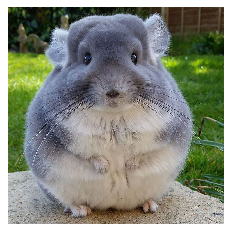

In [26]:
print("Great job! You've made it to the end of the lab!")
import matplotlib.image as mpimg
img = mpimg.imread('chinchilla.jpg')
imgplot = plt.imshow(img)
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)
plt.show()